## نظام معتمد على التعلم العميق للوسوم النحوية العربية والأصل المعجمي والتبنؤ بالسياق

**أهم ما تمّ عمله حتى الآن**
* جمع مدونة عربية متزنة (خمسة أوعية) تعكس العربية المعاصرة النموذجية انعكاسًا يُمثّل تنوعًا للوحدات المعجمية العربية، ونسبة كثافة معجمية عالية
* منهج تأصيل معجمي موحد يُبقي القسم الكلامي
للكلمة (التوكن) على قسمه النحوي دون تغيير
* تركنا التشكيل على الكلمات مرةً، ثم أزلناها مرةً أخرى. ظهرت نتائج نماذج الكلمات إلى متجه بدون الشكيل أفضل
* إمكانية تحسين نموذج الشَّبكات العصبِيَّة المتكَرّرة بشبكات الذَّاكرة القصيرةِ-الطَّويلةِ المدى بدلا من نموذج الحقول العشوائية المشروطة
* إمكانية تحسين نموذج حقيبية الكلمات المستمرة بدلا من تخطي الكلمة، وذلك بزيادة حجم البيانات 
* استخراج الكلمات ذات العلاقة بنموذج حقيبة الكلمات المستمرة
* استخراج الكلمات المختلفة سياقيا والمتشابة/المتقابة إملائيا بنموذج بيرت 
* اعتمدنا على نموذج مدرب مسبقا لبيرت، ويحتاج بناؤه من الصفر وتدريبه وفق التعلم الموجه وقتا أطول. لاحظنا أن في النموذج المدرّب مسبقا بعض الأخطاء في نظام التفريق، وسنعمل على تحسين ذلك ببناء نظام للتفريق ثم بناء نموذج بيرت بناء عليه، وعلى بياناتنا الخاصة بالفريق

## معلومات عن المدونة (البيانات اللغوية)

-	Standard--Academic (A):	10,512 tokens (before tokenizing); 10,657 tokens (after tokenizing); 10,612 tokens (after segmenting)
-	Standard-- Khutbah (K):	10,380 tokens (before tokenizing); 10,713 tokens (after tokenizing); 13,396 tokens (after segmenting)
-	Standard--Journalism (N): 10,408 tokens (before tokenizing); 11,019 tokens (after tokenizing); 12,584 13,396 tokens (after segmenting)
-	Standard--Official-Issues (O): 10,093 tokens (before tokenizing); 10,657 tokens (after tokenizing); 12,351 tokens (after segmenting)
-	Standard--Web (W): 10,097 tokens (before tokenizing); 10,706 tokens (after tokenizing); 12,365 tokens (after segmenting)

**The whole data (Talafeef.txt): 51,490 tokens (before tokenizing); 53,752 tokens (after tokenizing); 61,308 (61,312 IDs as in Talafeef.txt) tokens (after segmenting)**

# النماذج على الترتيب مكتوبة بالإنجليزية بغية الوضوح

All models are saved in a zip folder named as NLPiffy_GUI
1. CRF Model: (crf_model.sav)
2. RNN (LSTM) Model: (RNN_model.h5)
3. RNN (N-Gram): (RNN_tag2index.pkl and RNN_word2index.pkl)
4. Skip-Gram Model: (SkipG_model.pt)
5. CBOW Model: (cbow_model.h5 and CBOW_Embeddings.npz)
6. Pretrained BERT Model (bert-model.h5)
7. BERT (pre-trained araBERTv2): (tokenized_text.npz) and (token_vecs_cat_array.npz) and (tokenized_text.pkl). All are integrated into the GUI. We created the mdoel bert-model.h5 first, then we created a list of embeddings to use it at this stage. 

In [2]:
!pip install lazyme

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for lazyme: filename=lazyme-0.0.27-py3-none-any.whl size=8606 sha256=8eb3a44cec218cb1c5d076920621b46d6003ed030abe2778949f3aabeb458ad8
  Stored in directory: /root/.cache/pip/wheels/69/d3/f1/ba84128432d5b0c2408d2ae86ea09d743e28e4d50aca31d39e
Successfully built lazyme


# 1. 1. نموذج الحقول العشوائية المشروطة لتدريب واختبار تصنيف الوسوم النحوية
## Conditional Random Fields (CRF)

In [10]:
from lazyme import per_section
import nltk 
from collections import Counter
import numpy as np
import pandas as pd

In [11]:
dataset = pd.read_csv("/content/Talafeef.csv",usecols=['token','tpos'])
dataset.head()
dataset.isnull().sum()

token    0
tpos     0
dtype: int64

In [12]:
dataset.isnull().sum()

token    0
tpos     0
dtype: int64

In [13]:
dataset['tpos'].apply(lambda x:type(x)).value_counts()

<class 'str'>    61317
Name: tpos, dtype: int64

In [14]:
arabic_period_count = dataset.query('token=="."').shape[0]
print(f"Number of Periods: {arabic_period_count}")

Number of Periods: 1412


In [15]:
#end of the sentences
end_sent_index = dataset.query('token=="."').index

In [16]:
# Splitting the data into sentences using the period (.) as the unique identifier
sentences = []
sentence = []
for index, row in dataset.iterrows():
    sentence.append((row['token'], row['tpos']))  # Add both token and tpos as a tuple
    if row['token'] == '.':
        sentences.append(sentence)
        sentence = []

In [17]:
arabic_comma_sentences = [s for s in sentences if any(t[0] == '،' for t in s)]
print(arabic_comma_sentences[:10])

[[('مثال', 'N'), ('الصورة', 'N'), ('34', 'CD'), (':', 'PUNC'), ('صورتان', 'N'), ('شعاعيتان', 'N'), ('متطابقتان', 'JJ'), ('ل', 'IN'), ('القسم', 'N'), ('العلوي', 'JJ'), ('من', 'IN'), ('البطن', 'N'), ('تظهران', 'VBP'), ('غاز', 'N'), ('في', 'IN'), ('الشجرة', 'N'), ('الصفراوية', 'JJ'), ('،', 'PUNC'), ('يوجد', 'VBP'), ('تفرع', 'N'), ('خطوط', 'N'), ('سوداء', 'JJ'), ('غاز', 'N'), ('بارز', 'JJ'), ('نحو', 'N'), ('مركز', 'N'), ('الكبد', 'N'), ('أكبر', 'JJR'), ('و', 'CC'), ('أشد', 'JJR'), ('بروزا', 'N'), ('نحو', 'N'), ('السرة', 'N'), ('،', 'PUNC'), ('و', 'CC'), ('يوجد', 'VBP'), ('أيضا', 'N'), ('شبكة', 'N'), ('صفراوية', 'JJ'), ('واقعة', 'JJ'), ('على', 'IN'), ('الخط', 'N'), ('الناصف', 'JJ'), ('الأسهم', 'N'), ('البيضاء', 'N'), ('و', 'CC'), ('التي', 'WP'), ('تتوضع', 'VBP'), ('في', 'IN'), ('داخل', 'JJ'), ('القناة', 'N'), ('الصفراوية', 'JJ'), ('المشتركة', 'JJ'), ('و', 'CC'), ('هذا', 'DT'), ('يفسر', 'VBP'), ('أين', 'WRB'), ('يستطيع', 'VBP'), ('الغاز', 'N'), ('أن', 'RP'), ('ينتقل', 'VBP'), ('ب', 'IN'), ('

In [18]:
print(len(sentences))

1412


In [19]:
dataset_size = np.arange(len(sentences))
train_index = np.random.choice(dataset_size, int(len(sentences) * 0.8), replace=False)
test_index = np.setdiff1d(dataset_size, train_index)

In [20]:
train_index.shape

(1129,)

In [21]:
test_index.shape

(283,)

In [22]:
training_sentences = [sentences[i] for i in train_index]
test_sentences = [sentences[i] for i in test_index]

In [23]:
print (training_sentences[0])

[('اللهم', 'N'), ('من', 'RP'), ('أراد', 'VBD'), ('بلادنا', 'N'), ('و', 'CC'), ('ديننا', 'N'), ('و', 'CC'), ('عقيدتنا', 'N'), ('و', 'CC'), ('أمننا', 'N'), ('ب', 'IN'), ('سوء', 'N'), ('و', 'CC'), ('كيد', 'N'), ('ف', 'CC'), ('اردد', 'VBP'), ('كيده', 'N'), ('في', 'IN'), ('نحره', 'N'), ('و', 'CC'), ('أشغله', 'VB'), ('ب', 'IN'), ('نفسه', 'N'), ('يا', 'RP'), ('رب', 'N'), ('العالمين', 'N'), ('.', 'PUNC')]


In [24]:
def features(sentence, index):
    """ sentence: [w1, w2, ...], index: the index of the word """
    return {
        'word': sentence[index],
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        
        'prefix-1': sentence[index][0],
        #'prefix-2': sentence[index][:2],
        #'prefix-3': sentence[index][:3],
        #'prefix-4': sentence[index][:4],
        'suffix-1': sentence[index][-1],
        #'suffix-2': sentence[index][-2:],
        #'suffix-3': sentence[index][-3:],

        'prev_word1': '' if index == 0 else sentence[index - 1],
        
        'next_word1': '' if index == len(sentence) - 1 else sentence[index + 1],        
        
        'is_numeric': sentence[index].isdigit(),
    }

In [25]:
from nltk.tag.util import untag

def transform_to_dataset(tagged_sentences):
    X, y = [], []

    for tagged in tagged_sentences:
        try:
            X.append([features(untag(tagged), index) for index in range(len(tagged))])
            y.append([tag for _, tag in tagged])
        except ValueError:
            print(f"Problematic sentence: {tagged}")

    return X, y

X_train, y_train = transform_to_dataset(training_sentences)
X_test, y_test = transform_to_dataset(test_sentences)

print(len(X_train))
print(len(X_test))

1129
283


In [26]:
!pip install sklearn_crfsuite

import time
start_time = time.time()

from sklearn_crfsuite import CRF
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
 
crf = sklearn_crfsuite.CRF(algorithm='lbfgs',
    c1=0.01,
    c2=0.01,
    max_iterations=100000,
    all_possible_transitions=True)
crf.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.8 MB/s eta 0:00:00
--- 38.61729884147644 seconds ---


In [27]:
labels = list(crf.classes_)
labels

['N',
 'RP',
 'VBD',
 'CC',
 'IN',
 'VBP',
 'VB',
 'PUNC',
 'CD',
 'ABBREV',
 'FW',
 'JJ',
 'DT',
 'RB',
 'JJR',
 'WP',
 'PRP',
 'WRB',
 'VBN']

In [28]:
y_pred = crf.predict(X_test)

In [29]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
a = mlb.fit_transform([crf.classes_])
y_test_matrix = mlb.transform(y_test)
y_pred_matrix = mlb.transform(y_pred)

In [30]:
from sklearn import metrics
print(metrics.classification_report(y_test_matrix, y_pred_matrix, target_names=crf.classes_, digits=3))

              precision    recall  f1-score   support

           N      1.000     0.867     0.929        30
          RP      0.996     1.000     0.998       239
         VBD      0.981     1.000     0.990        52
          CC      1.000     0.989     0.994        88
          IN      1.000     0.800     0.889         5
         VBP      1.000     1.000     1.000       256
          VB      0.892     0.900     0.896       211
        PUNC      0.952     0.833     0.889        48
          CD      1.000     1.000     1.000       280
      ABBREV      1.000     0.977     0.989        44
          FW      1.000     1.000     1.000       283
          JJ      0.969     0.969     0.969        97
          DT      0.974     0.995     0.984       186
          RB      0.900     0.692     0.783        26
         JJR      0.912     0.864     0.887       132
          WP      0.500     0.176     0.261        17
         PRP      0.925     0.961     0.943       206
         WRB      0.900    

In [31]:
import time
start_time = time.time()

from sklearn_crfsuite import metrics
y_pred = crf.predict(X_test)
print("Accuracy = ",metrics.flat_accuracy_score(y_test, y_pred))
print ("Recall =", metrics.flat_recall_score(y_test, y_pred, average='weighted',  labels=labels))
print ("Precision =", metrics.flat_precision_score(y_test, y_pred, average='weighted',  labels=labels))
print ("F1 =", metrics.flat_f1_score(y_test, y_pred, average='weighted',  labels=labels))

print("--- %s seconds ---" % (time.time() - start_time))

Accuracy =  0.9262727272727272
Recall = 0.9262727272727272
Precision = 0.9241297653976086
F1 = 0.923770190122457
--- 0.19359421730041504 seconds ---


In [32]:
y_pred = crf.predict(X_test)
print ("F1 =", metrics.flat_f1_score(y_test, y_pred, average='weighted',  labels=labels))

F1 = 0.923770190122457


In [33]:
sentence = 'الله الرحمن الرحيم .'.split()
def pos_tag(sentence):
    sentence_features = [features(sentence, index) for index in range(len(sentence))]
    return list(zip(sentence, crf.predict([sentence_features])[0]))
 
print(pos_tag(sentence))

[('الله', 'N'), ('الرحمن', 'N'), ('الرحيم', 'JJ'), ('.', 'PUNC')]


# 1. 2. حفظ نموذج الحقول العشوائية المشروطة
## CRF

In [34]:
import pickle
filename = 'crf_model.sav'
pickle.dump(crf, open(filename, 'wb'))

In [35]:
import joblib
# Fit the CRF model
crf.fit(X_train, y_train)
# Save the CRF model
joblib.dump(crf, '/content/crf_model.sav')

['/content/crf_model.sav']

In [36]:
import pickle

# Save the CRF model
with open('/content/crf_model.pkl', 'wb') as f:
    pickle.dump(crf, f)

# Load the CRF model
with open('/content/crf_model.pkl', 'rb') as f:
    crf_model = pickle.load(f)

# Hyperparameter tuning using grid Search for CRF

# 2. 1. نموذج الشبكات العصبية المتكررة (شبكات الذَّاكرة القصيرة-الطويلة المدى)  
## RNN (LSTM)

In [37]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
!pip install keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from tensorflow.keras.optimizers import Adam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
# Read the dataset
dataset = pd.read_csv("/content/Talafeef.csv", usecols=['token', 'tpos'])

# Process the dataset to extract sentences and tags
sentences, tags = [], []
sentence, tag = [], []
for _, row in dataset.iterrows():
    if row["token"] == '.':
        sentences.append(sentence)
        tags.append(tag)
        sentence, tag = [], []
    else:
        sentence.append(row["token"])
        tag.append(row["tpos"])

# Add the last sentence if it doesn't end with a period
if len(sentence) > 0:
    sentences.append(sentence)
    tags.append(tag)

# Print the number of sentences
print("Number of sentences:", len(sentences))

# Get the first sentence and the first word and tag
if len(sentences) > 0 and len(sentences[0]) > 0:
    first_sentence = sentences[0]
    first_word, first_tag = first_sentence[0], tags[0][0]
    print("First word:", first_word)
    print("First tag:", first_tag)
else:
    print("No sentences found in the dataset.")


Number of sentences: 1412
First word: إذا
First tag: RP


In [40]:
sentences, sentence_tags = [], []
sentence, tags = [], []
for index, row in dataset.iterrows():
    sentence.append(row['token'])
    tags.append(row['tpos'])
    if row['token'] == '.':
        sentences.append(np.array(sentence))
        sentence_tags.append(np.array(tags))
        sentence, tags = [], []

In [41]:
sentences[2]

array(['و', 'حاليا', 'ف', 'إن', 'معظم', 'المرضى', 'غير', 'المستقرين',
       'الذين', 'يشك', 'لديهم', 'ب', 'استرواح', 'الصفاق', 'يخضعون',
       'مباشرة', 'ل', 'التصوير', 'المقطعي', 'المحوسب', '.'], dtype='<U9')

In [42]:
sentence_tags[2]

array(['CC', 'N', 'CC', 'RP', 'JJ', 'N', 'N', 'JJ', 'WP', 'VBP', 'RB',
       'IN', 'N', 'N', 'VBP', 'JJ', 'IN', 'N', 'JJ', 'JJ', 'PUNC'],
      dtype='<U4')

In [43]:
len(sentences[1]), len(sentence_tags[1000])

(26, 56)

In [44]:
(train_sentences, 
 test_sentences, 
 train_tags, 
 test_tags) = train_test_split(sentences, sentence_tags, test_size=0.2)

In [45]:
words, tags = set([]), set([])
 
for s in train_sentences:
    for w in s:
        words.add(w)
 
for ts in train_tags:
    for t in ts:
        tags.add(t)
 
word2index = {w: i + 2 for i, w in enumerate(list(words))}
word2index['-PAD-'] = 0  # The special value used for padding
word2index['-OOV-'] = 1  # The special value used for OOVs
 
tag2index = {t: i + 1 for i, t in enumerate(list(tags))}
tag2index['-PAD-'] = 0  # The special value used to padding

In [46]:
len(word2index)

10379

In [47]:
tag2index

{'VB': 1,
 'IN': 2,
 'JJ': 3,
 'VBN': 4,
 'JJR': 5,
 'PRP': 6,
 'VBD': 7,
 'CD': 8,
 'RB': 9,
 'DT': 10,
 'WRB': 11,
 'N': 12,
 'RP': 13,
 'ABBREV': 14,
 'VBP': 15,
 'CC': 16,
 'FW': 17,
 'PUNC': 18,
 'WP': 19,
 '-PAD-': 0}

In [48]:
train_sentences_X, test_sentences_X, train_tags_y, test_tags_y = [], [], [], []
 
for s in train_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    train_sentences_X.append(s_int)
 
for s in test_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    test_sentences_X.append(s_int)
 
for s in train_tags:
    train_tags_y.append([tag2index[t] for t in s])
 
for s in test_tags:
    test_tags_y.append([tag2index[t] for t in s])

In [49]:
print(train_sentences_X[0])
print(test_sentences_X[0])
print(train_tags_y[0])
print(test_tags_y[0])

[466, 5610, 3270, 5097, 5605, 4841, 1358, 9773, 9508, 4792, 4808, 9773, 9688, 2266, 466, 10083, 1905, 3718, 5648, 4519, 9241, 8076, 9640, 610, 3608, 2467, 4132, 6257, 466, 1128, 6257, 1358, 3385, 9042, 3609, 534, 1791, 7050, 10083, 9177, 610, 2452, 4807, 4682, 2499, 3385, 5648, 5616]
[4409, 10041, 466, 1, 10028, 3948, 185, 8982, 10091, 6573, 10091, 6406, 2709, 5668, 729, 10041, 4253, 3948, 1, 5533, 6062, 3014, 133, 6406, 8386, 1298, 1, 6406, 4505, 3168, 4253, 5123, 9390, 10083, 4038, 1, 2709, 3948, 1992, 8323, 4673, 3785, 303, 1, 10041, 3608, 129, 10083, 8310, 1085, 7210, 3948, 7420, 1, 5616]
[16, 13, 7, 12, 12, 12, 18, 2, 12, 10, 12, 2, 12, 12, 16, 2, 12, 15, 12, 2, 3, 12, 3, 2, 13, 15, 12, 3, 16, 12, 3, 18, 2, 12, 2, 12, 12, 12, 2, 12, 2, 12, 12, 12, 12, 2, 12, 18]
[12, 12, 16, 15, 12, 16, 15, 9, 12, 12, 12, 12, 12, 13, 15, 12, 7, 16, 7, 3, 11, 6, 12, 12, 12, 16, 12, 12, 3, 7, 7, 16, 7, 2, 9, 12, 12, 16, 7, 2, 12, 2, 13, 1, 12, 13, 2, 11, 12, 12, 11, 16, 13, 15, 18]


In [50]:
MAX_LENGTH = max([len(s) for s in train_sentences_X])
MAX_LENGTH

3105

In [51]:
train_sentences_X = pad_sequences(train_sentences_X, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(test_sentences_X, maxlen=MAX_LENGTH, padding='post')
train_tags_y = pad_sequences(train_tags_y, maxlen=MAX_LENGTH, padding='post')
test_tags_y = pad_sequences(test_tags_y, maxlen=MAX_LENGTH, padding='post')

In [52]:
len(train_sentences_X[0]),len(train_sentences_X[5])

(3105, 3105)

In [53]:
model = Sequential()
model.add(InputLayer(input_shape=(MAX_LENGTH, )))
model.add(Embedding(len(word2index), 128))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(len(tag2index))))
model.add(Activation('softmax'))
 
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3105, 128)         1328512   
                                                                 
 bidirectional (Bidirectiona  (None, 3105, 512)        788480    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 3105, 20)         10260     
 ibuted)                                                         
                                                                 
 activation (Activation)     (None, 3105, 20)          0         
                                                                 
Total params: 2,127,252
Trainable params: 2,127,252
Non-trainable params: 0
_________________________________________________________________


In [55]:
def to_categorical(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)

In [56]:
cat_train_tags_y = to_categorical(train_tags_y, len(tag2index))

In [57]:
cat_train_tags_y.shape

(1129, 3105, 20)

In [58]:
model.fit(train_sentences_X, to_categorical(train_tags_y, len(tag2index)), batch_size=128, epochs=40, validation_split=0.2)

Epoch 1/40
8/8 [==============================] - 17s 1s/step - loss: 1.6890 - accuracy: 0.8473 - val_loss: 0.1465 - val_accuracy: 0.9845
Epoch 2/40
8/8 [==============================] - 7s 922ms/step - loss: 0.1345 - accuracy: 0.9861 - val_loss: 0.1111 - val_accuracy: 0.9845
Epoch 3/40
8/8 [==============================] - 7s 883ms/step - loss: 0.0563 - accuracy: 0.9871 - val_loss: 0.0473 - val_accuracy: 0.9879
Epoch 4/40
8/8 [==============================] - 7s 930ms/step - loss: 0.0409 - accuracy: 0.9891 - val_loss: 0.0395 - val_accuracy: 0.9896
Epoch 5/40
8/8 [==============================] - 7s 892ms/step - loss: 0.0366 - accuracy: 0.9901 - val_loss: 0.0368 - val_accuracy: 0.9902
Epoch 6/40
8/8 [==============================] - 8s 948ms/step - loss: 0.0328 - accuracy: 0.9913 - val_loss: 0.0397 - val_accuracy: 0.9903
Epoch 7/40
8/8 [==============================] - 7s 913ms/step - loss: 0.0317 - accuracy: 0.9912 - val_loss: 0.0391 - val_accuracy: 0.9902
Epoch 8/40
8/8 [======

In [59]:
scores = model.evaluate(test_sentences_X, to_categorical(test_tags_y, len(tag2index)))
print(f"{model.metrics_names[1]}: {scores[1] * 100}")

9/9 [==============================] - 1s 128ms/step - loss: 0.0231 - accuracy: 0.9933
accuracy: 99.33493733406067


In [60]:
test_samples = [
    "إذا تم إجراء صورة شعاعية ل البطن و صورة شعاعية ل الصدر ب وضعية الوقوف و مازال تشخيص استرواح الصفاق غير مؤكد ف عندها يجب طلب تصوير مقطعي محوسب ل البطن .".split(),
]
print(test_samples)

[['إذا', 'تم', 'إجراء', 'صورة', 'شعاعية', 'ل', 'البطن', 'و', 'صورة', 'شعاعية', 'ل', 'الصدر', 'ب', 'وضعية', 'الوقوف', 'و', 'مازال', 'تشخيص', 'استرواح', 'الصفاق', 'غير', 'مؤكد', 'ف', 'عندها', 'يجب', 'طلب', 'تصوير', 'مقطعي', 'محوسب', 'ل', 'البطن', '.']]


In [61]:
test_samples_X = []
for s in test_samples:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
    test_samples_X.append(s_int)
 
test_samples_X = pad_sequences(test_samples_X, maxlen=MAX_LENGTH, padding='post')
print(test_samples_X)

[[9851 3270  992 ...    0    0    0]]


In [62]:
predictions = model.predict(test_samples_X)
print(predictions, predictions.shape)

1/1 [==============================] - 1s 720ms/step
[[[2.4239480e-02 6.7803590e-03 1.4114192e-01 ... 2.4427839e-03
   5.8488343e-02 8.2946522e-03]
  [2.1790367e-02 6.2090796e-03 1.3488978e-01 ... 2.2918703e-03
   7.0508882e-02 7.7144867e-03]
  [1.8491639e-02 5.2619022e-03 9.8328963e-02 ... 1.9654343e-03
   5.9428673e-02 6.4718835e-03]
  ...
  [9.9999106e-01 3.9185534e-07 4.0105324e-08 ... 5.7122918e-07
   2.9324117e-06 1.9954112e-07]
  [9.9998665e-01 6.2608416e-07 5.3281596e-08 ... 9.0568295e-07
   3.7275167e-06 3.1438282e-07]
  [9.9998164e-01 9.0795635e-07 6.8095623e-08 ... 1.2972095e-06
   4.5859420e-06 4.4967894e-07]]] (1, 3105, 20)


In [63]:
def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequence = []
        for categorical in categorical_sequence:
            token_sequence.append(index[np.argmax(categorical)])
 
        token_sequences.append(token_sequence)
 
    return token_sequences

In [64]:
print(logits_to_tokens(predictions, {i: t for t, i in tag2index.items()})[0])

['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'PUNC', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-',

In [65]:
from keras import backend as K
 
def ignore_class_accuracy(to_ignore=0):
    def ignore_accuracy(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)
 
        ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return ignore_accuracy

In [66]:
model = Sequential()
model.add(InputLayer(input_shape=(MAX_LENGTH, )))
model.add(Embedding(len(word2index), 128))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(len(tag2index))))
model.add(Activation('softmax'))
 
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy', ignore_class_accuracy(0)])
 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3105, 128)         1328512   
                                                                 
 bidirectional_1 (Bidirectio  (None, 3105, 512)        788480    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 3105, 20)         10260     
 tributed)                                                       
                                                                 
 activation_1 (Activation)   (None, 3105, 20)          0         
                                                                 
Total params: 2,127,252
Trainable params: 2,127,252
Non-trainable params: 0
_________________________________________________________________


In [67]:
model.fit(train_sentences_X, to_categorical(train_tags_y, len(tag2index)), batch_size=128, epochs=40, validation_split=0.2)

Epoch 1/40
8/8 [==============================] - 12s 1s/step - loss: 1.7106 - accuracy: 0.8463 - ignore_accuracy: 0.0031 - val_loss: 0.1550 - val_accuracy: 0.9845 - val_ignore_accuracy: 0.0000e+00
Epoch 2/40
8/8 [==============================] - 8s 951ms/step - loss: 0.1390 - accuracy: 0.9861 - ignore_accuracy: 0.0000e+00 - val_loss: 0.1267 - val_accuracy: 0.9845 - val_ignore_accuracy: 0.0000e+00
Epoch 3/40
8/8 [==============================] - 7s 921ms/step - loss: 0.0573 - accuracy: 0.9861 - ignore_accuracy: 0.0104 - val_loss: 0.0430 - val_accuracy: 0.9845 - val_ignore_accuracy: 0.2000
Epoch 4/40
8/8 [==============================] - 8s 1s/step - loss: 0.0380 - accuracy: 0.9895 - ignore_accuracy: 0.3357 - val_loss: 0.0378 - val_accuracy: 0.9904 - val_ignore_accuracy: 0.4082
Epoch 5/40
8/8 [==============================] - 7s 929ms/step - loss: 0.0339 - accuracy: 0.9909 - ignore_accuracy: 0.3826 - val_loss: 0.0355 - val_accuracy: 0.9904 - val_ignore_accuracy: 0.4098
Epoch 6/40
8/

In [68]:
predictions = model.predict(test_sentences_X)
print(logits_to_tokens(predictions, {i: t for t, i in tag2index.items()}))

9/9 [==============================] - 2s 120ms/step


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [69]:
from sklearn.metrics import accuracy_score

# Evaluate the model
scores = model.evaluate(test_sentences_X, to_categorical(test_tags_y, len(tag2index)))
print(f"{model.metrics_names[1]}: {scores[1] * 100}")

# Make predictions
predictions = model.predict(test_sentences_X)

# Convert the categorical predictions to token sequences
predicted_tags = logits_to_tokens(predictions, {i: t for t, i in tag2index.items()})

# Flatten the true and predicted tags for the test set
true_tags_1d = [tag for tags_sequence in test_tags_y for tag in tags_sequence]
predicted_tags_1d = [tag for tags_sequence in predicted_tags for tag in tags_sequence]

# Calculate and print the overall accuracy
overall_accuracy = accuracy_score(true_tags_1d, predicted_tags_1d)
print(f"Overall Accuracy: {overall_accuracy:.2f}")

9/9 [==============================] - 1s 131ms/step - loss: 0.0239 - accuracy: 0.9933 - ignore_accuracy: 0.4855
accuracy: 99.33448433876038
9/9 [==============================] - 1s 119ms/step
Overall Accuracy: 0.00


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


# 2. 2. حفظ نموذج الشبكات العصبية التكراراية
## RNN (LSTM)

In [70]:
# Save Model
model.save("RNN_model.h5")

In [71]:
import pickle
a_file = open("RNN_tag2index.pkl", "wb")
pickle.dump(tag2index, a_file)
a_file.close()

In [72]:
b_file = open("RNN_word2index.pkl", "wb")
pickle.dump(word2index, b_file)
b_file.close()

# 3. 1. نموذج الكلمة إلى متجه (تخطي الكلمة) 
## Word2Vec (Skip-Gram Model)

In [ ]:
#!pip install --upgrade allennlp
!pip install allennlp==2.5.0
!pip install google-cloud-storag
!pip install overrides
!pip install python-bidi
!pip install arabic_reshaper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.4/681.4 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 42.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 804.1/804.1 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.2/594.2 kB 44.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 52.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━

In [ ]:
import math
import random
from collections import Counter
import numpy as np
import torch
import torch.optim as optim
from allennlp.common.file_utils import cached_path
from allennlp.data.data_loaders import SimpleDataLoader
from allennlp.data.dataset_readers.dataset_reader import DatasetReader
from allennlp.data.fields import LabelField
from allennlp.data.instance import Instance
from allennlp.data.vocabulary import Vocabulary
from allennlp.models import Model
from allennlp.modules.token_embedders import Embedding
from allennlp.training import GradientDescentTrainer
from overrides import overrides
from scipy.stats import spearmanr
from torch.nn import CosineSimilarity
from torch.nn import functional
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt
%matplotlib inline
from bidi.algorithm import get_display
import arabic_reshaper

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
@DatasetReader.register("skip_gram")
class SkipGramReader(DatasetReader):
    def __init__(self, window_size=5, vocab: Vocabulary=None):
        """A DatasetReader for reading a plain text corpus and producing instances
        for the SkipGram model.
        When vocab is not None, this runs sub-sampling of frequent words as described
        in (Mikolov et al. 2013).
        """
        super().__init__()
        self.window_size = window_size
        self.reject_probs = None
        if vocab:
            self.reject_probs = {}
            threshold = 1.e-3
            token_counts = vocab._retained_counter['token_in']  # HACK
            total_counts = sum(token_counts.values())
            for _, token in vocab.get_index_to_token_vocabulary('token_in').items():
                counts = token_counts[token]
                if counts > 0:
                    normalized_counts = counts / total_counts
                    reject_prob = 1. - math.sqrt(threshold / normalized_counts)
                    reject_prob = max(0., reject_prob)
                else:
                    reject_prob = 0.
                self.reject_probs[token] = reject_prob

    def _subsample_tokens(self, tokens):
        """Given a list of tokens, runs sub-sampling.
        Returns a new list of tokens where rejected tokens are replaced by Nones.
        """
        new_tokens = []
        for token in tokens:
            reject_prob = self.reject_probs.get(token, 0.)
            if random.random() <= reject_prob:
                new_tokens.append(None)
            else:
                new_tokens.append(token)

        return new_tokens

    @overrides
    def _read(self, file_path: str):
        with open(cached_path(file_path), "r") as text_file:
            for line in text_file:
                tokens = line.strip().split(' ')
                tokens = tokens[:1000000]  # TODO: remove

                if self.reject_probs:
                    tokens = self._subsample_tokens(tokens)
                    print(tokens[:200])  # for debugging

                for i, token in enumerate(tokens):
                    if token is None:
                        continue

                    token_in = LabelField(token, label_namespace='token_in')

                    for j in range(i - self.window_size, i + self.window_size + 1):
                        if j < 0 or i == j or j > len(tokens) - 1:
                            continue

                        if tokens[j] is None:
                            continue

                        token_out = LabelField(tokens[j], label_namespace='token_out')
                        yield Instance({'token_in': token_in, 'token_out': token_out})

In [ ]:
EMBEDDING_DIM = 256
BATCH_SIZE = 256
CUDA_DEVICE = -1

In [ ]:
class SkipGramModel(Model):
    def __init__(self, vocab, embedding_in):
        super().__init__(vocab)
        self.embedding_in = embedding_in
        self.linear = torch.nn.Linear(
            in_features=EMBEDDING_DIM,
            out_features=vocab.get_vocab_size('token_out'),
            bias=False)

    def forward(self, token_in, token_out):
        embedded_in = self.embedding_in(token_in)
        logits = self.linear(embedded_in)
        loss = functional.cross_entropy(logits, token_out)

        return {'loss': loss}

In [ ]:
def get_related(token: str, embedding: Model, vocab: Vocabulary, num_synonyms: int = 10):
    """Given a token, return a list of top N most similar words to the token."""
    token_id = vocab.get_token_index(token, 'token_in')
    token_vec = embedding.weight[token_id]
    cosine = CosineSimilarity(dim=0)
    sims = Counter()

    for index, token in vocab.get_index_to_token_vocabulary('token_in').items():
        sim = cosine(token_vec, embedding.weight[index]).item()
        sims[token] = sim

    return sims.most_common(num_synonyms)

In [ ]:
reader = SkipGramReader()
talafeef = reader.read("/content/Talafeef--Seg.txt")

In [ ]:
talafeef = list(talafeef)
print(len(talafeef))

591610


In [ ]:
vocab = Vocabulary.from_instances(
    talafeef, min_count={'token_in': 2, 'token_out': 2},max_vocab_size=100000)

building vocab: 100%|##########| 591610/591610 [00:03<00:00, 175104.35it/s]


In [ ]:
data_loader = SimpleDataLoader(talafeef, batch_size=BATCH_SIZE)
data_loader.index_with(vocab)

In [ ]:
vocab.get_vocab_size

<bound method Vocabulary.get_vocab_size of Vocabulary with namespaces:  token_in, Size: 11421 || token_out, Size: 11421 || Non Padded Namespaces: {'*labels', '*tags'}>

In [ ]:
embedding_in = Embedding(num_embeddings=vocab.get_vocab_size('token_in'),
                         embedding_dim=EMBEDDING_DIM)

In [ ]:
model = SkipGramModel(vocab=vocab,
                      embedding_in=embedding_in)

In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
trainer = GradientDescentTrainer(
    model=model,
    optimizer=optimizer,
    data_loader=data_loader,
    num_epochs=5,
    cuda_device=-1)

In [ ]:
trainer.train()

batch_loss: 8.1715, loss: 8.4074 ||: 100%|##########| 2311/2311 [07:24<00:00,  5.20it/s]
batch_loss: 7.5726, loss: 7.3374 ||: 100%|##########| 2311/2311 [07:12<00:00,  5.35it/s]
batch_loss: 7.3219, loss: 7.0631 ||: 100%|##########| 2311/2311 [06:59<00:00,  5.51it/s]
batch_loss: 7.1669, loss: 6.8931 ||: 100%|##########| 2311/2311 [06:52<00:00,  5.60it/s]
batch_loss: 7.0170, loss: 6.6899 ||: 100%|##########| 2311/2311 [06:52<00:00,  5.61it/s]


{'best_epoch': 4,
 'peak_worker_0_memory_MB': 4450.59765625,
 'peak_gpu_0_memory_MB': 0,
 'training_duration': '0:35:20.642721',
 'epoch': 4,
 'training_loss': 6.689859426676685,
 'training_worker_0_memory_MB': 4450.59765625,
 'training_gpu_0_memory_MB': 0.0}

# 3. 2. حفظ نموذج تخطي الكلمة
## Save Skip-Gram Model

In [ ]:
torch.save(model, r"SkipG_model.pt")
#with open("model.th", 'wb') as f:
#    torch.save(model.state_dict(), f)
#trainer.save('model.pt')

In [ ]:
print(get_related('العلوم', embedding_in, vocab))

[('العلوم', 1.0), ('البعد', 0.8738469481468201), ('إدراك', 0.8327703475952148), ('المعرفي', 0.8213313817977905), ('المتعدد', 0.8201298713684082), ('الذاتي', 0.816584050655365), ('التوجهات', 0.8160153031349182), ('الممارسة', 0.8123476505279541), ('الأجزاء', 0.8099591732025146), ('الفكرية', 0.8098580837249756)]


In [ ]:
print(get_related('محمد', embedding_in, vocab))

[('محمد', 1.0), ('بارك', 0.796276330947876), ('رسولك', 0.7836217284202576), ('عبدك', 0.7565821409225464), ('نبينا', 0.733247697353363), ('آله', 0.7294031977653503), ('صل', 0.6782127618789673), ('صحبه', 0.6646692156791687), ('صلاة', 0.6468511819839478), ('نبيك', 0.6378940939903259)]


In [ ]:
print(get_related('السعودية', embedding_in, vocab))

[('السعودية', 1.0), ('العربية', 0.7960535883903503), ('المملكة', 0.7714268565177917), ('ملك', 0.6914434432983398), ('عبدالعزيز', 0.6540446877479553), ('سعود', 0.6532337665557861), ('الاطلاع', 0.6478955149650574), ('أرامكو', 0.6412606835365295), ('اللغة', 0.6384416222572327), ('الأبناء', 0.6322089433670044)]


In [ ]:
print(get_related('النظام', embedding_in, vocab))

[('النظام', 1.0), ('تعديل', 0.7710747122764587), ('أحكام', 0.738693356513977), ('الأساسي', 0.7344191074371338), ('تعدل', 0.7169671654701233), ('اختصاصاته', 0.6856377124786377), ('الرسمية', 0.6849857568740845), ('ينشر', 0.6825264096260071), ('السابعة', 0.6725610494613647), ('الجريدة', 0.6708585023880005)]


In [ ]:
print(get_related('الشباب', embedding_in, vocab))

[('الشباب', 1.0), ('توافر', 0.7212899923324585), ('مهارات', 0.7198715806007385), ('التضخم', 0.719375491142273), ('المطلوبة', 0.71819007396698), ('التعلم', 0.7122114896774292), ('العالية', 0.7094316482543945), ('الوظائف', 0.7035050988197327), ('الاستثمارات', 0.7028219699859619), ('العملية', 0.6995164155960083)]


In [ ]:
token_id = vocab.get_token_index("الله", 'token_in')
token_vec = embedding_in.weight[token_id]

In [ ]:
cosine = CosineSimilarity(dim=0)

In [ ]:
vocab.get_vocab_size

<bound method Vocabulary.get_vocab_size of Vocabulary with namespaces:  token_in, Size: 11421 || token_out, Size: 11421 || Non Padded Namespaces: {'*labels', '*tags'}>

In [ ]:
import numpy as np
np.unique(np.array(talafeef))

array(['token_in', 'token_out'], dtype='<U9')

In [ ]:
len(talafeef)

591610

In [ ]:
vocab.get_vocab_size

<bound method Vocabulary.get_vocab_size of Vocabulary with namespaces:  token_in, Size: 11421 || token_out, Size: 11421 || Non Padded Namespaces: {'*labels', '*tags'}>

In [ ]:
vocab.get_token_to_index_vocabulary('token_in').items()

dict_items([('@@PADDING@@', 0), ('@@UNKNOWN@@', 1), ('و', 2), ('،', 3), ('ب', 4), ('ل', 5), ('.', 6), ('في', 7), ('من', 8), ('على', 9), ('أن', 10), ('الله', 11), ('ف', 12), ('ما', 13), ('لا', 14), ('إلى', 15), ('المادة', 16), ('عن', 17), ('أو', 18), ('هذا', 19), ('التي', 20), ('ذلك', 21), ('مجلس', 22), ('إن', 23), ('كل', 24), ('هو', 25), ('هذه', 26), ('عليه', 27), ('مع', 28), ('الصورة', 29), ('الأمعاء', 30), ('اللهم', 31), ('بعد', 32), ('الذي', 33), ('قد', 34), ('النظام', 35), ('تظهر', 36), ('الوزراء', 37), ('إلا', 38), ('له', 39), ('هي', 40), ('الملك', 41), ('سلم', 42), ('قال', 43), ('إذا', 44), ('كما', 45), ('كان', 46), ('رئيس', 47), ('صلى', 48), ('بين', 49), ('يكون', 50), ('ك', 51), ('المجلس', 52), ('أكثر', 53), ('الدولة', 54), ('أي', 55), ('حيث', 56), ('شكل', 57), ('المنطقة', 58), ('الهيئة', 59), ('غير', 60), ('أنه', 61), ('البطن', 62), ('الشعاعية', 63), ('تكون', 64), ('يا', 65), ('الذين', 66), ('لم', 67), ('العمل', 68), ('عشرة', 69), ('خلال', 70), ('عليها', 71), ('الغاز', 72), ('ح

In [ ]:
get_related("محمد",embedding_in,vocab)

[('محمد', 1.0),
 ('بارك', 0.796276330947876),
 ('رسولك', 0.7836217284202576),
 ('عبدك', 0.7565821409225464),
 ('نبينا', 0.733247697353363),
 ('آله', 0.7294031977653503),
 ('صل', 0.6782127618789673),
 ('صحبه', 0.6646692156791687),
 ('صلاة', 0.6468511819839478),
 ('نبيك', 0.6378940939903259)]

In [ ]:
vocab.get_vocab_size("token_out")

11421

In [ ]:
embedding_in.weight.shape

torch.Size([11421, 256])

In [ ]:
pca = PCA(n_components=2)

In [ ]:
pca_components = pca.fit_transform(embedding_in.weight.detach().numpy())

In [ ]:
pca_components[0:50].shape

(50, 2)

<ipython-input-106-767981d084c7>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pca_components[:100,0],pca_components[:100,1],cmap='plasma')


Text(0, 0.5, 'PCA2')

/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


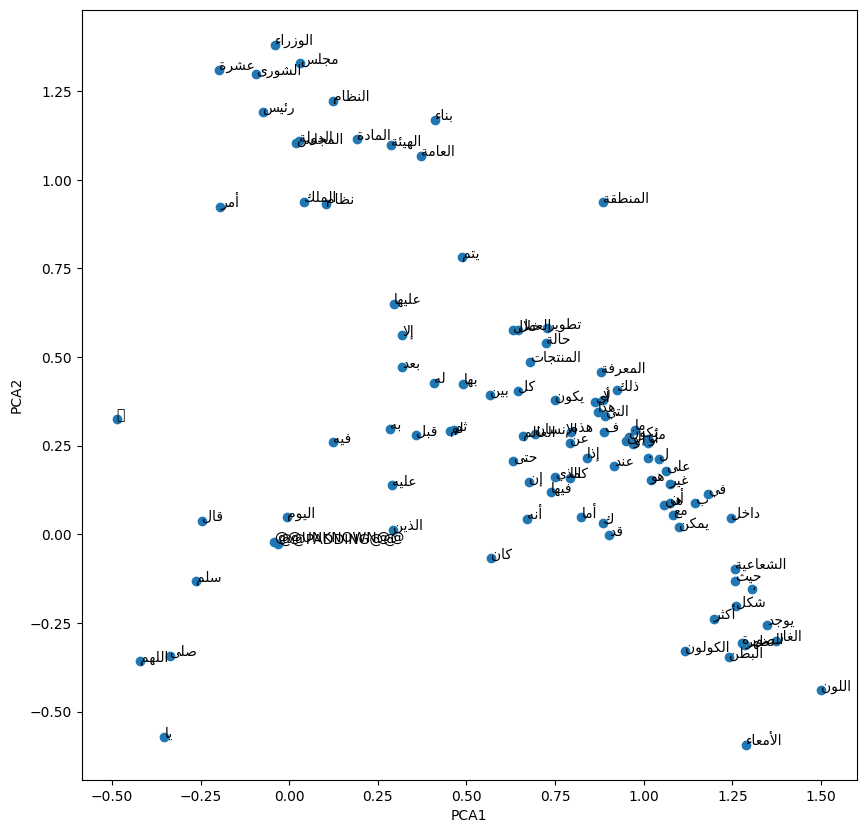

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
arabic_stopwords = stopwords.words("arabic")
plt.figure(figsize=(10,10))
labels=[vocab.get_token_from_index(i,'token_in') for i in range(100) if i not in arabic_stopwords ]
plt.scatter(pca_components[:100,0],pca_components[:100,1],cmap='plasma')
for i in range(100):
  xword = arabic_reshaper.reshape(labels[i])
  artext = get_display(xword)
  plt.annotate(artext,(pca_components[i,0],pca_components[i,1]))
plt.xlabel("PCA1")
plt.ylabel("PCA2")

# 4. 1. نموذج الكلمة إلى متجه (حقيبة الكلمات المستمرة)
## Word2Vec (CBOW model)

In [ ]:
import numpy as np
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from collections import Counter

In [ ]:
data=open("/content/Talafeef--Seg.txt",'r')
talafeef_data = [text for text in data if text.count(' ') >= 2]

In [ ]:
talafeef_data[0]

'عام جديد و وقفة محاسبة . الشيخ صالح بن عبدالله بن حميد . تاريخ الخطبة . الخطبة الأولى . الحمد ل الله الحمد ل الله تفرد ب العز و القهر و الكبرياء و استأثر ب الملك و التدبير و البقاء قهر الخلق ب ما كتب عليه من الفناء أحمده سبحانه والى ب الإنعام النعم المتكاثرة و حذر ب الانتقام ب النقم القاهرة و أشهد أن لا إله إلا الله وحده لا شريك له له الحمد في الأولى و الآخرة و أشهد أن سيدنا و نبينا محمدا عبد الله و رسوله أيده ب الحجج الظاهرة و البراهين الباهرة صلى الله و سلم و بارك عليه و على آله و أصحابه النجوم الزاهرة و الكواكب السائرة و التابعين و من تبعهم ب إحسان و سلم تسليما كثيرا مزيدا لا تحصره حاصرة . أما بعد ف أوصيكم أيها الناس و نفسي ب تقوى الله ف اتقوا الله رحمكم الله و حاسبوا أنفسكم ف من حاسب نفسه عرف ب ليله و الناس نائمون و ب نهاره و الناس مفطرون و ب ورعه و الناس يخلطون و ب صمته و الناس يخوضون و ب خوفه إذا الناس غافلون يحفظ لسانه و يبكي على خطيئته كفى ب خشية الله علما و كفى ب الاغترار جهلا و ترك الخطيئة خير من طلب التوبة و رب شهوة ساعة أورثت حزنا طويلا من عمل صالحا ف ل نفسه و من أساء ف عل

In [ ]:
vectorize = Tokenizer()
vectorize.fit_on_texts(talafeef_data)
talafeef_data = vectorize.texts_to_sequences(talafeef_data)
total_vocab = sum(len(s) for s in talafeef_data)
word_count = len(vectorize.word_index) + 1
window_size = 2

In [ ]:
word_count

11415

In [ ]:
total_vocab

57741

In [ ]:
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.2/178.2 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: google-auth
    Found existing installation: google-auth 1.35.0
    Uninstalling google-auth-1.35.0:
      Successfully uninstalled google-auth-1.35.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-storage 1.38.0 requires google-auth<2.0dev,>=1.11.0, but you have google-auth 2.17.3 which is incompatible.
google-cloud-core 1.7.3 requires google-auth<2.0dev,>=1.24.0, but you have google-auth 2.17.3 which is incompatible.


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

In [ ]:
def cbow_model(data, window_size, total_vocab):
    total_length = window_size*2
    for text in data:
        text_len = len(text)
        for idx, word in enumerate(text):
            context_word = []
            target   = []            
            begin = idx - window_size
            end = idx + window_size + 1
            context_word.append([text[i] for i in range(begin, end) if 0 <= i < text_len and i != idx])
            target.append(word)
            contextual = pad_sequences(context_word, maxlen=total_length)
            final_target = np_utils.to_categorical(target, total_vocab)
            yield(contextual, final_target)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=total_vocab, output_dim=100, input_length=window_size*2))
model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(100,)))
model.add(Dense(total_vocab, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
for i in range(10):
    cost = 0
    for x, y in cbow_model(talafeef_data, window_size, total_vocab):
        cost += model.train_on_batch(x, y)
    print(i, cost)

0 520395.9030479975
1 468921.81911498914
2 419760.3207287198
3 367777.0257905666


In [ ]:
model.summary()

# 4. 2. حفظ نموذج حقيبة الكلمات المستمرة
## Save CBOW Model 

In [ ]:
model.save("cbow_model.h5")

In [ ]:
weights = model.get_weights()[0]
w2v_my = {}

for word, index in vectorize.word_index.items():
    w2v_my[word] = weights[index]

np.savez('CBOW_Embeddings.npz', **w2v_my)
embeddings = np.load('CBOW_Embeddings.npz')

In [ ]:
embeddings["الله"]

In [ ]:
def get_related(token: str, num_synonyms: int = 10):
    """Given a token, return a list of top N most similar words to the token."""
    token_vec = w2v_my[token]
    sims = Counter()

    for w,vec in w2v_my.items():
        sim = np.dot(token_vec, vec)/(np.linalg.norm(token_vec) * np.linalg.norm(vec))
        sims[w] = sim

    return sims.most_common(num_synonyms)

In [ ]:
get_related("أشعة",10)

In [ ]:
get_related("مرض",10)

In [ ]:
get_related("التقنية",10)

In [ ]:
np.array(list(w2v_my.values())).shape

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt
%matplotlib inline
!pip install arabic_reshaper python-bidi
from bidi.algorithm import get_display
import arabic_reshaper

In [ ]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(np.array(list(w2v_my.values())))

In [ ]:
arabic_stopwords = stopwords.words("arabic")
w2v_my_no_stop=dict()
for key,value in w2v_my.items():
  if key not in arabic_stopwords:
    w2v_my_no_stop[key]=value

In [ ]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(np.array(list(w2v_my_no_stop.values())))
plt.figure(figsize=(10,10))
labels= list(embeddings.keys())[:100]
plt.scatter(pca_components[:100,0],pca_components[:100,1],cmap='plasma')
for i in range(100):
  xword = arabic_reshaper.reshape(labels[i])
  artext = get_display(xword)
  plt.annotate(artext,(pca_components[i,0],pca_components[i,1]))
plt.xlabel("PCA1")
plt.ylabel("PCA2")

# 5.1. araBERTv2

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
import logging
import glob
import os
#from bert_function import bert_processing, get_related
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
! curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
! sudo apt-get install git-lfs
! git lfs install
!  clone https://huggingface.co/aubmindlab/bert-base-arabertv2
! tar -C ./MODEL_NAME -zxvf /content/bert-base-arabertv02/tf1_model.tar.gz

In [ ]:
! pip install pyarabic

In [ ]:
! git clone https://github.com/aub-mind/arabert.git

In [ ]:
! pip install farasapy
from farasa.segmenter import FarasaSegmenter 
from arabert.preprocess import ArabertPreprocessor

In [ ]:
model_name = "aubmindlab/bert-base-arabertv2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

arabert_prep = ArabertPreprocessor(model_name=model_name)

In [ ]:
with open("/content/Talafeef--Seg.txt",'r', encoding='utf-8') as f:
    dataset_tokens = f.read()

tokens = dataset_tokens.split(" ")
number_of_tokens = len(tokens)

In [ ]:
preprocessed_text = arabert_prep.preprocess(dataset_tokens)

In [ ]:
preprocessed_text.split(".")[0]

In [ ]:
segmenter = FarasaSegmenter(interactive=True)
segmented = segmenter.segment(preprocessed_text)

In [ ]:
segmented

In [ ]:
splitted_text = preprocessed_text.split(".")
marked_text=''
for sent in splitted_text:
  marked_text = marked_text +  "[CLS] " + sent + " [SEP]"

# Split the sentence into tokens.
#tokenized_text = tokenizer.tokenize(marked_text)
tokenized_text = tokenizer.tokenize(marked_text)
# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
#for tup in zip(tokenized_text, indexed_tokens):
  #print('{:<12} {:>6,}'.format(tup[0], tup[1]))

segments_ids=[]
id=0
for token in tokenized_text:
  if token != '[CLS]':
    segments_ids.append(id)
  else:
    segments_ids.append(id)
    id = id + 1
print(len(indexed_tokens))

In [ ]:
tokenized_text[:10]

In [ ]:
len(segments_ids), len(tokenized_text)

In [ ]:
indexed_tokens[:10], segments_ids[:10],tokenized_text[:10]

In [ ]:
def bert_processing (model, segments_ids, indexed_tokens, tokens_in_chunk):
		
	tensor_input_ids = torch.tensor(indexed_tokens).unsqueeze(0)
	segments_tensor = torch.tensor(segments_ids).unsqueeze(0)
	output = model(tensor_input_ids,segments_tensor)

	hidden_states = output[0][0]

	token_vecs_sum = []

	for token in hidden_states.detach().numpy():
		token_vecs_sum.append(token)

		# `token` is a [12 x 768] tensor

		# Sum the vectors from the last four layers.
		#sum_vec = torch.sum(token[-4:], dim=0)
		
		# Use `sum_vec` to represent `token`.
		#token_vecs_sum.append(sum_vec)

	#print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))


	token_vecs_cat_array=np.empty((tokens_in_chunk,768),float)
	for t in token_vecs_sum:
	  np.append(token_vecs_cat_array,np.array(t))
	
	#token_vecs_cat_array.shape
	return token_vecs_cat_array


In [ ]:
final_token_vecs_array = np.empty((len(indexed_tokens),768),float)

for i in range(0,len(segments_ids),512):
    x=i
    chunk_segments_ids = segments_ids[x:x+512]
    chunk_indexed_tokens = indexed_tokens[x:x+512]
    chunk_token_vecs = bert_processing(model=model, segments_ids=chunk_segments_ids,
                                       indexed_tokens=chunk_indexed_tokens, 
                                       tokens_in_chunk=len(chunk_indexed_tokens))
    #np.append(final_token_vecs_array, np.array(chunk_token_vecs))
    final_token_vecs_array[x:x+512] = chunk_token_vecs

In [ ]:
final_token_vecs_array.shape

In [ ]:
from collections import Counter
def get_related(token: str, num_synonyms: int = 10, 
                tokenized_text = tokenized_text ,final_token_vecs_array=final_token_vecs_array):
    """Given a token, return a list of top N most similar words to the token."""
    token_vec = final_token_vecs_array[tokenized_text.index(token)]
    sims = Counter()

    for i in range (final_token_vecs_array.shape[0]):
        sim = np.dot(token_vec, final_token_vecs_array[i])/(np.linalg.norm(token_vec) * np.linalg.norm(final_token_vecs_array[i]))
        sims[tokenized_text[i]] = sim

    return sims.most_common(num_synonyms)

# 5.2. Save BERT model  

In [ ]:
#save token vecs
from numpy import asarray
from numpy import savez_compressed 
savez_compressed('token_vecs_cat_array.npz', final_token_vecs_array)

In [ ]:
#test if saved token vec saving done right (it should return array([[ True,  True,  True, ..., )
from numpy import load
token_vecs_cat_array2 = load('token_vecs_cat_array.npz')
token_vecs_cat_array2==final_token_vecs_array

data= load('token_vecs_cat_array.npz')
token_vecs_cat_array2 = data['arr_0']  
token_vecs_cat_array2==final_token_vecs_array

In [ ]:
#save tokenized text
import pickle
open_file = open("new_tokenized_text.pkl", "wb")
pickle.dump(tokenized_text, open_file)
open_file.close()

In [ ]:
#check if tokenized text saving done right (should return True)
open_file = open("new_tokenized_text.pkl", "rb")
tokenized_text2 = pickle.load(open_file)
open_file.close()

tokenized_text2==tokenized_text 

In [ ]:
#save tokenized vec (method 2)
import pickle
open_file = open("token_vecs_cat_array.pkl", "wb")
pickle.dump(final_token_vecs_array, open_file)
open_file.close() 

In [ ]:
#check if tokenized text saving done right (method 2)
open_file = open("token_vecs_cat_array.pkl", "rb")
tokenized_vec2 = pickle.load(open_file)
open_file.close()

tokenized_vec2==final_token_vecs_array 

In [ ]:
get_related("غاز",10)

In [ ]:
get_related("مقطع",10)

In [ ]:
get_related("كبد",10)

# Visualizations

In [ ]:
final_token_vecs_array[500:1000].shape

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(final_token_vecs_array[:500])

In [ ]:
! pip install python-bidi
! pip install arabic-reshaper
from bidi.algorithm import get_display
import arabic_reshaper

In [ ]:
plt.figure(figsize=(7,5))
labels=tokenized_text
plt.scatter(pca_components[10:20,0],pca_components[10:20,1],cmap='plasma')
for i in range(10,20):
  xword = arabic_reshaper.reshape(labels[i])
  artext = get_display(xword)
  plt.annotate(artext,(pca_components[i,0],pca_components[i,1]))
plt.xlabel("PCA1")
plt.ylabel("PCA2")

In [ ]:
!pip install umap-learn matplotlib

In [ ]:
import random

# Extract and process tokens
token_list = []
for token_id in inputs["input_ids"].squeeze():
    token = tokenizer.convert_ids_to_tokens(token_id.item())
    if len(token) > 4:
        token = token.replace('#', '')  # Remove the '#' symbol
        token_list.append((token, token_id.item()))

# Randomly select 20 words
num_words = 20
selected_tokens = random.sample(token_list, num_words)

# Plot 2D embeddings
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

# Annotate the selected words
for token, token_id in selected_tokens:
    i = np.where(inputs["input_ids"].squeeze() == token_id)[0][0]
    bidi_token = process_arabic(token)
    adjust_annotation(plt.gca(), embeddings_2d[i, 0], embeddings_2d[i, 1], bidi_token, fontsize=fontsize)

plt.show()